In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../')
from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

from pystackreg import StackReg
from skimage.transform import warp,AffineTransform

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
def crop_center(img,crop_size):

    if type(crop_size) == tuple:
        crop_x,crop_y = crop_size
    elif type(crop_size) == int:
        crop_x = crop_size
        crop_y = crop_size
    
    y,x = img.shape[-2::]
    startx = x//2-(crop_x//2)
    starty = y//2-(crop_y//2)        

    return img[...,starty:starty+crop_y,startx:startx+crop_x]

In [3]:
#### ALL PARAMETERS DEFINED HERE ####

supervised = True

# Data paths
data_path = Path(r"E:\dl_monalisa\Data\Mito_fixed\dump\train")
crop_size = (1200,1200)


# Data parameters
noise_level = "all" # "all",list of int, or int
clean = "avg"
clip = -5 # False or clip value
registration = False
augment = False
normGMM = False # put True if data was normalized to create the GMM
display = True # display images or not
clip = -5 # False or clip value


# Load GMM
noiseModelPath = r"E:\dl_monalisa\Data\Mito_fixed\noise_models\final\GMM_Noiseall_SigAVG_Clip-5_noNorm.npz"
noise_model_params = np.load(noiseModelPath)
noiseModel = GaussianMixtureNoiseModel(params = noise_model_params, device = device)
print(f"Loaded noise model: {noiseModelPath}")

# Training prm
patch_size = 64
gaussian_noise_std = None

# Training-specific
beta = 0.01 # loss = recon_loss + beta * kl_loss
batch_size=64
virtual_batch = 8
lr=1e-5
max_epochs = 500
steps_per_epoch=400
test_batch_size=10

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
blocks_per_layer = 6
batchnorm = True
free_bits = 1.0

# Model name for saving
modelName = f"Mito_fixed_GMMmito_clip{clip}_{num_latents}Lat_{blocks_per_layer}Blocks_betaKL{beta}"
if supervised:
    modelName = modelName +"_supervised"

save_model_basedir = "./Trained_model/" 
print(f"Trained model will be saved at: {save_model_basedir}")
print(f"Model save name: {modelName}")


Loaded noise model: E:\dl_monalisa\Data\Mito_fixed\noise_models\final\GMM_Noiseall_SigAVG_Clip-5_noNorm.npz
Trained model will be saved at: ./Trained_model/
Model save name: Mito_fixed_GMMmito_clip-5_5Lat_6Blocks_betaKL0.01_supervised


In [4]:
##### Load data ####
signal = []
observation = []
filters = ['tif','tiff']

files = os.listdir(data_path)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files.remove(f)

for f in files:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files.remove(f)

print(f"\nFound {len(files)} files.\n")
if isinstance(noise_level,list) or noise_level == "all":
    mltplNoise = True
else:
    mltplNoise = False


for f in files:
    
    if clean == "avg":
        im_signal = np.mean(imread(data_path / f)[0:5],axis=0)
    else:
        raise ValueError("avg gt is the only one available for now for actin")
    
    # noise level selection
    if noise_level == "all":
        im_obs  = imread(data_path / f)
    elif isinstance(noise_level,int) or isinstance(noise_level,list):
        try:
            im_obs = imread(data_path / f)[noise_level]
        except IndexError:
            print(f"Image {f} ignored because of IndexError") 
            continue

    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = clip
        im_signal[im_signal<clip] = clip

    im_obs = crop_center(im_obs,crop_size)
    im_signal = crop_center(im_signal,crop_size)
    
    observation.append(im_obs)
    signal.append(im_signal)

    print(f"File {f}: shape: {im_obs.shape}")



Found 22 files.

File 12h08m06s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h11m06s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (17, 1200, 1200)
File 12h14m16s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (19, 1200, 1200)
File 12h17m11s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (19, 1200, 1200)
File 12h19m41s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h23m09s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h25m12s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h28m54s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h31m33s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (19, 1200, 1200)
File 12h34m06s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (18, 1200, 1200)
File 12h39m29s_rec_scan00_CAM.hdf5_multi.0.reconstruction.tiff: shape: (20, 1200, 1200)
File 12h44m23s

In [5]:
full_signal = []
full_obs = []
for i,obs in enumerate(observation):
    sig = signal[i]
    sig = (sig - np.mean(sig))/np.std(sig)
    for frame in obs:
        norm_sig = sig * np.std(frame) + np.mean(frame)
        full_signal.append(norm_sig)
        full_obs.append(frame)

observation = np.stack(full_obs)
signal = np.stack(full_signal)
minVal = np.min(signal)
maxVal = np.max(signal)
print(f"\n\nConcatenated arrays:\tSignal: {signal.shape}\tObservation: {observation.shape}")



Concatenated arrays:	Signal: (413, 1200, 1200)	Observation: (413, 1200, 1200)


In [6]:
# Split into train and val, define gt data if supervised

train_data = observation[:int(0.85*observation.shape[0])]
val_data= observation[int(0.85*observation.shape[0]):]
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)
if augment:
    train_data = utils.augment_data(train_data) ### Data augmentation disabled for fast training, but can be enabled
### Optional part with GT data if supervised###
if supervised:
    train_data_gt = signal[:int(0.85*signal.shape[0])]
    val_data_gt = signal[int(0.85*signal.shape[0]):]
    print("Shape of GT training images:", train_data.shape, "Shape of validation images:", val_data.shape)
    if augment:
        train_data_gt = utils.augment_data(train_data_gt) ### Data augmentation disabled for fast training, but can be enabled


Shape of training images: (351, 1200, 1200) Shape of validation images: (62, 1200, 1200)
Shape of GT training images: (351, 1200, 1200) Shape of validation images: (62, 1200, 1200)


In [7]:
# Patches extraction

img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)

if not supervised:
    train_images = utils.extract_patches(train_data, patch_size, num_patches)
    val_images = utils.extract_patches(val_data, patch_size, num_patches)
else:
    train_images,train_images_gt = utils.extract_patches_supervised(train_data,train_data_gt, patch_size, num_patches)
    val_images,val_images_gt  = utils.extract_patches_supervised(val_data,val_data_gt, patch_size, num_patches)

 # We limit validation patches to 1000 to speed up training but it is not necessary
val_images = val_images[:1000]
if supervised:
    val_images_gt = val_images_gt [:1000] 
    
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

100%|██████████| 62/62 [00:00<00:00, 90.17it/s]

Shape of training images: (123201, 64, 64) Shape of validation images: (1000, 64, 64)


In [8]:
# Choose make_data_manager for supervised training or make_data_manager 2 for supervised


train_loader, val_loader, data_mean, data_std = boilerplate._make_datamanager_supervised(train_images, train_images_gt, 
                                                                                                      val_images, val_images_gt,
                                                                                                      batch_size, upsamp=1)


# Here we ensure that steps_per_epoch not bigger than len(train_loader)
# It never goes into validation otherwise, and so it never saves the model.
steps_per_epoch=min(len(train_loader)-1,steps_per_epoch)
print(steps_per_epoch)

400


In [9]:
del train_images,train_images_gt,val_images,val_images_gt,train_data,train_data_gt,val_data,val_data_gt,observation,signal

torch.Size([64, 64, 64]) torch.Size([64, 64, 64])
(64, 64)
(64, 64)


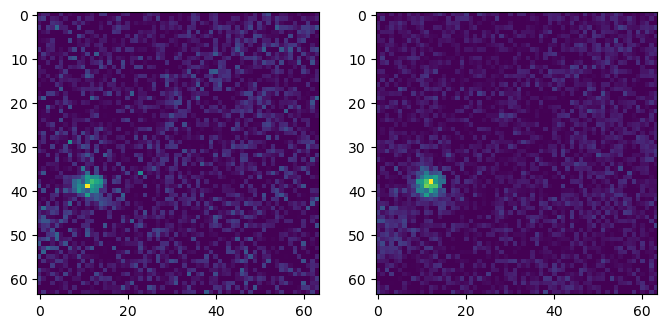

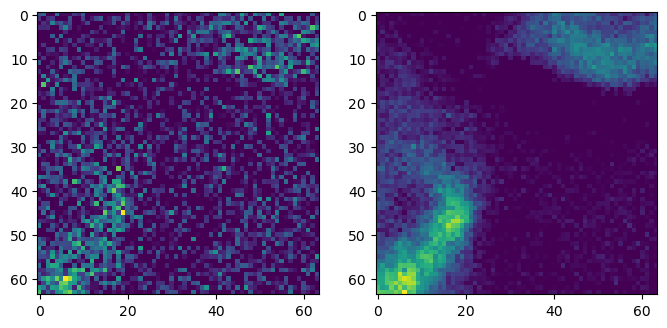

In [10]:
# if supervised: Display of paired dataset to check that it is still matching in the loader  

if supervised:
    batch_idx, (x, y) = next(enumerate(train_loader))
    print(x.shape,y.shape)
    x2 = x.cpu().numpy()
    x2 = x2[0]
    print(x2.shape)

    y2 = y.cpu().numpy()
    y2 = y2[0]

    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(x2)
    plt.subplot(1,2,2)
    plt.imshow(y2)

    batch_idx, (x, y) = next(enumerate(val_loader))

    x2 = x.cpu().numpy()
    x2 = x2[0]
    print(x2.shape)

    y2 = y.cpu().numpy()
    y2 = y2[0]

    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(x2)
    plt.subplot(1,2,2)
    plt.imshow(y2)

In [ ]:
# Train network

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=(64,64)).cuda()

model.train() # Model set in training mode

training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=save_model_basedir,
                       train_loader=train_loader,val_loader=val_loader,test_loader=None,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=modelName,val_loss_patience=100,beta=beta)

Epoch[1/500] Training Loss: 4.856 Reconstruction Loss: 4.847 KL Loss: 0.929
saving ./Trained_model/model/Mito_fixed_GMMmito_clip-5_5Lat_6Blocks_betaKL0.01_supervised_last_vae.net
saving ./Trained_model/model/Mito_fixed_GMMmito_clip-5_5Lat_6Blocks_betaKL0.01_supervised_best_vae.net
Patience: 0 Validation Loss: 5.217512130737305 Min validation loss: 5.217512130737305
Time for epoch: 494seconds
Est remaining time: 2 days, 20:28:26 or 246506 seconds
----------------------------------------
Epoch[2/500] Training Loss: 4.359 Reconstruction Loss: 4.334 KL Loss: 2.577
saving ./Trained_model/model/Mito_fixed_GMMmito_clip-5_5Lat_6Blocks_betaKL0.01_supervised_last_vae.net
Patience: 1 Validation Loss: 6.445603847503662 Min validation loss: 5.217512130737305
Time for epoch: 496seconds
Est remaining time: 2 days, 20:36:48 or 247008 seconds
----------------------------------------
Epoch[3/500] Training Loss: 4.147 Reconstruction Loss: 4.114 KL Loss: 3.297
saving ./Trained_model/model/Mito_fixed_GMMmi

# Plotting losses

In [ ]:
directory_path = "./Trained_model/" 
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

In [ ]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()